First we have to add the .zip for the BSDS500 dataset https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500 and from this Breast Cancer dataset https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data.

Once we have the datasets you should be able to run the code below to run the models.

First we are creating a simple generation model that will take an image and an edge map. This generation model will then output a new greyscale image similar to the orignal image.

In [ ]:
#Make a simple generation model that takes an edge map - Control Net uses diffusion model but for testing we are using a simple model

import torch
import torch.nn as nn
import torch.nn.functional as F

#Simple model takes in image and edgemap returns greyscale generated image
class ControlNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ControlNet, self).__init__()

        # Encoder
        self.enc1_img = self.conv_block(in_channels, 64)
        self.enc1_edge = self.conv_block(in_channels, 64)    # Output: [B, 64, 256, 256]
        self.enc2_img = self.conv_block(64, 128)              # Output: [B, 128, 128, 128]
        self.enc2_edge = self.conv_block(64, 128)             # Output: [B, 128, 128, 128]
        self.enc3_img = self.conv_block(128, 256)             # Output: [B, 256, 64, 64]
        self.enc3_edge = self.conv_block(128, 256)            # Output: [B, 256, 64, 64]
        self.enc4_img = self.conv_block(256, 512)             # Output: [B, 512, 32, 32]
        self.enc4_edge = self.conv_block(256, 512)            # Output: [B, 512, 32, 32]

        # Bottleneck
        self.bottleneck = self.conv_block(512, 512)           # Output: [B, 512, 32, 32]

        # Decoder
        self.dec4 = self.upconv_block(512, 256)               # Output: [B, 256, 64, 64]
        self.reduce_channels_768_to_512 = nn.Conv2d(768, 512, kernel_size=1)  # Reduce channels from 768 to 512
        self.dec3 = self.conv_block(512, 256)                 # Output: [B, 256, 64, 64]
        self.dec2 = self.upconv_block(256, 128)               # Output: [B, 128, 128, 128]
        self.reduce_channels_384_to_256 = nn.Conv2d(384, 256, kernel_size=1)  # Reduce channels from 384 to 256
        self.dec1 = self.conv_block(256, 128)                 # Output: [B, 128, 128, 128]

        # Additional upsampling step to bring to 256x256
        self.dec1_up = self.upconv_block(128, 128)            # Output: [B, 128, 256, 256]

        self.final = nn.Conv2d(128, out_channels, kernel_size=1)  # Output: [B, out_channels, 256, 256]

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0),  # Doubles spatial dimensions
            nn.ReLU(inplace=True)
        )

    def forward(self, image, edge_map):
        # Encoder forward pass for images
        enc1_img = self.enc1_img(image)                     # [B, 64, 256, 256]
        enc2_img = self.enc2_img(F.max_pool2d(enc1_img, 2)) # [B, 128, 128, 128]
        enc3_img = self.enc3_img(F.max_pool2d(enc2_img, 2)) # [B, 256, 64, 64]
        enc4_img = self.enc4_img(F.max_pool2d(enc3_img, 2)) # [B, 512, 32, 32]

        # Encoder forward pass for edge maps
        enc1_edge = self.enc1_edge(edge_map)                 # [B, 64, 256, 256]
        enc2_edge = self.enc2_edge(F.max_pool2d(enc1_edge, 2)) # [B, 128, 128, 128]
        enc3_edge = self.enc3_edge(F.max_pool2d(enc2_edge, 2)) # [B, 256, 64, 64]
        enc4_edge = self.enc4_edge(F.max_pool2d(enc3_edge, 2)) # [B, 512, 32, 32]

        # Bottleneck
        bottleneck = self.bottleneck(enc4_img)               # [B, 512, 32, 32]

        # Decoder forward pass
        dec4 = self.dec4(bottleneck)                         # [B, 256, 64, 64]

        # Concatenate with corresponding encoder features and reduce channels
        dec4_combined = torch.cat((dec4, enc3_img, enc3_edge), dim=1)  # [B, 768, 64, 64]
        dec4_reduced = self.reduce_channels_768_to_512(dec4_combined)  # [B, 512, 64, 64]
        dec3 = self.dec3(dec4_reduced)                      # [B, 256, 64, 64]
        dec2 = self.dec2(dec3)                              # [B, 128, 128, 128]

        # Concatenate with corresponding encoder features and reduce channels
        dec2_combined = torch.cat((dec2, enc2_img, enc2_edge), dim=1)  # [B, 384, 128, 128]
        dec2_reduced = self.reduce_channels_384_to_256(dec2_combined)  # [B, 256, 128, 128]
        dec1 = self.dec1(dec2_reduced)                      # [B, 128, 128, 128]

        # Additional upsampling to bring it back to [B, 128, 256, 256]
        dec1_up = self.dec1_up(dec1)                        # [B, 128, 256, 256]

        output = self.final(dec1_up)                        # [B, out_channels, 256, 256]

        return output


In [ ]:
#We will use BSDS500 dataset to train generation model this code will unzip the dataset

import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/archive.zip'  # Update with your zip file path
extract_path = '/content/BSDS500'  # Specify the folder to extract to

# Create a directory to extract the files
os.makedirs(extract_path, exist_ok=True)

# Attempt to unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f'Files extracted to {extract_path}')
except zipfile.BadZipFile:
    print("Error: The file is not a zip file or it is corrupted.")
except FileNotFoundError:
    print("Error: The specified file does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


Files extracted to /content/BSDS500


In [ ]:
#pre process the data to train model

import os
import cv2
import torch
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from google.colab import drive
from google.colab import files
import zipfile


# Set the path to the dataset (update this based on extracted folder structure)
dataset_path = '/content/BSDS500/images/train'  # Adjust if needed

class BSDS500EdgeMapDataset(Dataset):
    def __init__(self, root, transform_image=None, transform_edge=None):
        self.root = root
        self.transform_image = transform_image
        self.transform_edge = transform_edge
        self.image_files = [f for f in os.listdir(root) if f.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format

        image_np = np.array(image)
        edge_map = cv2.Canny(image_np, 100, 200)  # Apply Canny edge detection
        edge_map = Image.fromarray(edge_map).convert('L')  # Edge map as single channel (grayscale)

        # Repeat the single-channel edge map to create a 3-channel edge map
        edge_map = edge_map.convert('RGB')  # Convert back to RGB format to create 3 channels

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_edge:
            edge_map = self.transform_edge(edge_map)

        return image, edge_map

# Define transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for RGB images
])

transform_edge = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # You can normalize edge maps if needed, but it's optional
])

# Initialize the dataset
bsds500_dataset = BSDS500EdgeMapDataset(root=dataset_path, transform_image=transform_image, transform_edge=transform_edge)

# Create DataLoader
train_loader = DataLoader(bsds500_dataset, batch_size=8, shuffle=True)

# Example of iterating through the dataset
for images, edge_maps in train_loader:
    print("Batch of images shape:", images.shape)  # Should be [batch_size, 3, 256, 256]
    print("Batch of edge maps shape:", edge_maps.shape)  # Should be [batch_size, 3, 256, 256]
    break


Batch of images shape: torch.Size([8, 3, 256, 256])
Batch of edge maps shape: torch.Size([8, 3, 256, 256])


In [ ]:
#train generation model

import os
import cv2
import torch
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm  # Import tqdm for progress bars


# Set the device to CPU or GPU based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the device
model = ControlNet(in_channels=3, out_channels=3).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10  # Adjust the number of epochs based on your needs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (images, edge_maps) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images = images.to(device)  # Move images to the appropriate device
        edge_maps = edge_maps.to(device)  # Move edge maps to the appropriate device

        # Forward pass
        outputs = model(images, edge_maps)

        # Calculate loss
        loss = criterion(outputs, images)  # Compare output to original image (or adjust as needed)
        running_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:  # Log every 10 batches
          print(f'Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'control_net_model.pth')

Epoch 1/10:  40%|████      | 10/25 [00:05<00:08,  1.82it/s]

Batch [10/25], Loss: 0.2581


Epoch 1/10:  80%|████████  | 20/25 [00:09<00:02,  1.83it/s]

Batch [20/25], Loss: 0.0766


Epoch 1/10: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Epoch [1/10], Loss: 0.1783


Epoch 2/10:  40%|████      | 10/25 [00:04<00:08,  1.81it/s]

Batch [10/25], Loss: 0.0703


Epoch 2/10:  80%|████████  | 20/25 [00:09<00:02,  1.81it/s]

Batch [20/25], Loss: 0.0550


Epoch 2/10: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Epoch [2/10], Loss: 0.0601


Epoch 3/10:  40%|████      | 10/25 [00:04<00:08,  1.81it/s]

Batch [10/25], Loss: 0.0644


Epoch 3/10:  80%|████████  | 20/25 [00:09<00:02,  1.82it/s]

Batch [20/25], Loss: 0.0519


Epoch 3/10: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Epoch [3/10], Loss: 0.0474


Epoch 4/10:  40%|████      | 10/25 [00:04<00:08,  1.85it/s]

Batch [10/25], Loss: 0.0333


Epoch 4/10:  80%|████████  | 20/25 [00:09<00:02,  1.87it/s]

Batch [20/25], Loss: 0.0297


Epoch 4/10: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


Epoch [4/10], Loss: 0.0334


Epoch 5/10:  40%|████      | 10/25 [00:04<00:07,  1.88it/s]

Batch [10/25], Loss: 0.0232


Epoch 5/10:  80%|████████  | 20/25 [00:09<00:02,  1.89it/s]

Batch [20/25], Loss: 0.0222


Epoch 5/10: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch [5/10], Loss: 0.0229


Epoch 6/10:  40%|████      | 10/25 [00:04<00:07,  1.89it/s]

Batch [10/25], Loss: 0.0185


Epoch 6/10:  80%|████████  | 20/25 [00:09<00:02,  1.90it/s]

Batch [20/25], Loss: 0.0167


Epoch 6/10: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Epoch [6/10], Loss: 0.0195


Epoch 7/10:  40%|████      | 10/25 [00:04<00:07,  1.89it/s]

Batch [10/25], Loss: 0.0136


Epoch 7/10:  80%|████████  | 20/25 [00:09<00:02,  1.90it/s]

Batch [20/25], Loss: 0.0195


Epoch 7/10: 100%|██████████| 25/25 [00:11<00:00,  2.22it/s]


Epoch [7/10], Loss: 0.0165


Epoch 8/10:  40%|████      | 10/25 [00:04<00:07,  1.89it/s]

Batch [10/25], Loss: 0.0116


Epoch 8/10:  80%|████████  | 20/25 [00:09<00:02,  1.89it/s]

Batch [20/25], Loss: 0.0217


Epoch 8/10: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch [8/10], Loss: 0.0142


Epoch 9/10:  40%|████      | 10/25 [00:04<00:07,  1.88it/s]

Batch [10/25], Loss: 0.0093


Epoch 9/10:  80%|████████  | 20/25 [00:09<00:02,  1.88it/s]

Batch [20/25], Loss: 0.0157


Epoch 9/10: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch [9/10], Loss: 0.0134


Epoch 10/10:  40%|████      | 10/25 [00:04<00:08,  1.87it/s]

Batch [10/25], Loss: 0.0120


Epoch 10/10:  80%|████████  | 20/25 [00:09<00:02,  1.86it/s]

Batch [20/25], Loss: 0.0116


Epoch 10/10: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch [10/10], Loss: 0.0129


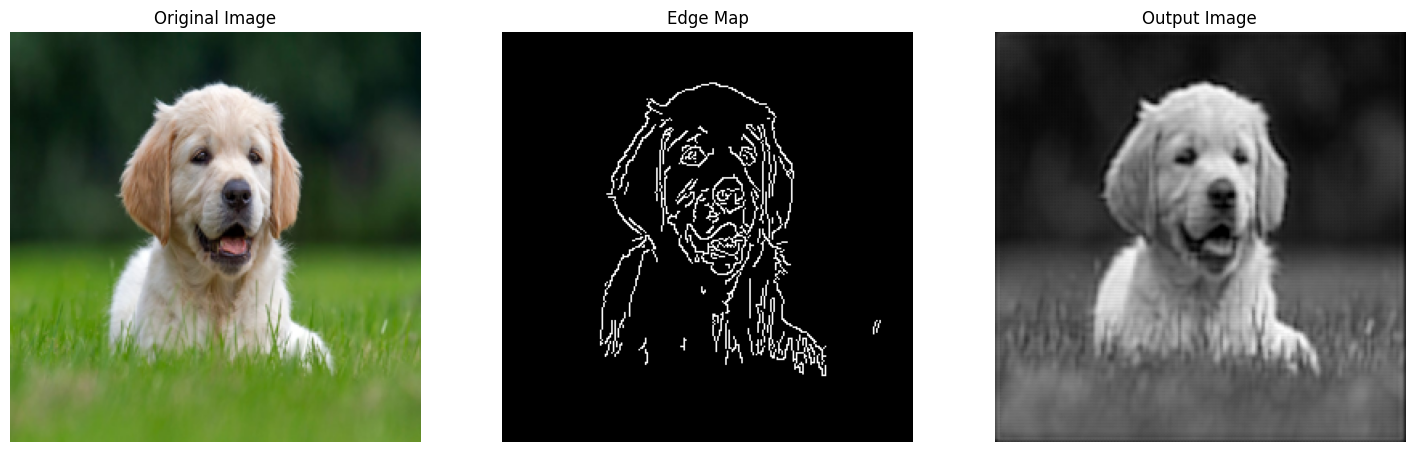

In [ ]:
#test example from generation model

import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode

def load_image(image_path):
    # Load image
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Resize to match training dimensions
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

def generate_edge_map(image_tensor):
    # Convert tensor back to NumPy array and to the original image format
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
    image_np = (image_np * 255).astype(np.uint8)  # Convert to [0, 255]

    # Convert to grayscale for edge detection
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    # Generate edge map using Canny edge detector
    edge_map = cv2.Canny(gray_image, 100, 200)
    edge_map = cv2.resize(edge_map, (256, 256))  # Resize to match training dimensions
    edge_map = edge_map.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Convert edge map to 3 channels by repeating the single channel
    edge_map_rgb = np.stack([edge_map] * 3, axis=0)  # Shape: (3, 256, 256)
    edge_map_tensor = torch.tensor(edge_map_rgb, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    return edge_map_tensor, edge_map  # Return both tensor and edge map for display

def test_model(image_path):
    # Load and preprocess the image
    image_tensor = load_image(image_path)

    # Generate edge map
    edge_map_tensor, edge_map = generate_edge_map(image_tensor)

    # Perform inference
    with torch.no_grad():  # Disable gradient calculation
        output = model(image_tensor, edge_map_tensor)  # Get the model output

    return output.squeeze().cpu().numpy(), edge_map  # Return output and edge map for visualization

def visualize_output(original_image_path, output_image, edge_map):
    # Load the original image for comparison
    original_image = Image.open(original_image_path).convert('RGB')
    original_image = original_image.resize((256, 256))

    # Adjust output image shape for visualization
    output_image = output_image.transpose(1, 2, 0)  # Transpose to (H, W, C)

    # Check if the output image has 3 channels
    if output_image.shape[2] == 3:
        output_image = output_image.mean(axis=2)  # Convert to grayscale by averaging channels

    # Ensure the output image is in the correct format for display
    output_image = np.clip(output_image * 255, 0, 255).astype(np.uint8)  # Scale to [0, 255]

    # Display the original, edge map, and output images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Edge Map')
    plt.imshow(edge_map, cmap='gray')  # Display edge map in grayscale
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Output Image')
    plt.imshow(output_image, cmap='gray')  # Output image in grayscale
    plt.axis('off')

    plt.show()

# Example usage remains the same
if __name__ == "__main__":
    test_image_path = 'dog.jpg'  # Replace with your test image path
    output_image, edge_map = test_model(test_image_path)
    visualize_output(test_image_path, output_image, edge_map)

Now that we have our generation model we are going to prepare our breast cancer dataset. First we have to clean the breast cancer dataset and remove all masked images from the data.

Then we will create training and test sets from this cleaned dataset. The test set will 20 percent of the cleaned dataset.

In [ ]:
#get breast cancer data and clean the data - remove all masked images
import zipfile
import os
from PIL import Image

# Step 1: Extract the zip file
zip_file = 'BreastCancerImages.zip'
output_folder = 'BreastCancerImages'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

# Step 2: Remove all '_mask.png' images from the dataset
def remove_mask_images(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('_mask.png'):
                os.remove(os.path.join(root, file))

remove_mask_images(output_folder)

# Step 3: Copy only original images (without '_mask') to a new clean folder
def copy_original_images(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each image in the dataset
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if not file.endswith('_mask.png') and file.endswith(('.png', '.jpg', '.jpeg')):
                # Copy original image to the new folder
                img_path = os.path.join(root, file)
                new_img_path = os.path.join(output_folder, os.path.relpath(img_path, input_folder))

                # Create any necessary subdirectories in the output folder
                new_img_dir = os.path.dirname(new_img_path)
                if not os.path.exists(new_img_dir):
                    os.makedirs(new_img_dir)

                # Copy the image
                img = Image.open(img_path)
                img.save(new_img_path)

# Set the directories for the image classes
input_folder = 'BreastCancerImages/BreastCancerImages'  # Modify this if your structure is different
clean_output_folder = 'CleanOriginalDataset'

# Copy only the original images (without masks) to the clean dataset folder
copy_original_images(input_folder, clean_output_folder)

print(f"Clean dataset saved in {clean_output_folder}.")

Clean dataset saved in CleanOriginalDataset.


In [ ]:
#split the clean dataset into train and test (20 percent)
import os
import random
import shutil
from PIL import Image

# Function to move 20% of images to a test set folder
def split_dataset(input_folder, output_folder, test_folder, test_size=0.2):
    # Create the output and test folders if they don't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    all_images = []

    # Collect all image paths from the input folder
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                all_images.append(img_path)

    # Shuffle the images and select 20% for the test set
    random.shuffle(all_images)
    num_test_images = int(len(all_images) * test_size)
    test_images = all_images[:num_test_images]
    train_images = all_images[num_test_images:]

    # Move the test images to the test folder
    for img_path in test_images:
        relative_path = os.path.relpath(img_path, input_folder)
        test_img_path = os.path.join(test_folder, relative_path)

        # Create any necessary subdirectories in the test folder
        test_img_dir = os.path.dirname(test_img_path)
        if not os.path.exists(test_img_dir):
            os.makedirs(test_img_dir)

        shutil.move(img_path, test_img_path)  # Move the image to the test folder

    # Ensure the remaining images are still in the original folder structure
    for img_path in train_images:
        relative_path = os.path.relpath(img_path, input_folder)
        new_img_path = os.path.join(output_folder, relative_path)

        # Create necessary subdirectories for the remaining training images
        train_img_dir = os.path.dirname(new_img_path)
        if not os.path.exists(train_img_dir):
            os.makedirs(train_img_dir)

        # Move the image back to the original folder (if it's not already there)
        shutil.move(img_path, new_img_path)

    print(f"Moved {num_test_images} images to {test_folder}.")
    print(f"Remaining images in the dataset: {len(train_images)}.")

clean_original_dataset = 'CleanOriginalDataset'
new_clean_dataset = 'TrainSet'  # After moving 20% out, remaining 80% will stay here
test_set_folder = 'TestSet'     # 20% of the data will be moved here

# Split the dataset into 80% training and 20% testing
split_dataset(clean_original_dataset, new_clean_dataset, test_set_folder, test_size=0.2)

Moved 0 images to TestSet.
Remaining images in the dataset: 0.


Now we are going to create two new data sets using the generation model. The first generated data set will have the orginal images plus the generated images. The seconded generated data set will have the orginial images plus the generated images plus images with some noise.

In [ ]:
#for all the images in the training data generate a duplicate
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

# Set device for model and tensor operations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Resize to match training dimensions
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# Function to generate edge map from the image
def generate_edge_map(image_tensor):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy (H, W, C)
    image_np = (image_np * 255).astype(np.uint8)  # Convert to [0, 255]

    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edge_map = cv2.Canny(gray_image, 100, 200)  # Canny edge detection
    edge_map = cv2.resize(edge_map, (256, 256))  # Resize edge map to 256x256
    edge_map = edge_map.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Convert to 3-channel format for consistency with the model
    edge_map_rgb = np.stack([edge_map] * 3, axis=0)  # Shape: (3, 256, 256)
    edge_map_tensor = torch.tensor(edge_map_rgb, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    return edge_map_tensor

# Function to generate a new image using the model
def generate_image_with_model(image_tensor, edge_map_tensor):
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image_tensor, edge_map_tensor)  # Model inference with input image and edge map
    return output

# Function to save images to a folder (in grayscale)
def save_image(image_tensor, save_path, is_grayscale=False):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy
    image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255] for saving

    # If the image is grayscale, average the RGB channels
    if is_grayscale:
        image_np = image_np.mean(axis=2).astype(np.uint8)  # Convert to grayscale by averaging channels

    image = Image.fromarray(image_np)
    image.save(save_path)

# Updated function to process and save images into the combined train set with subfolders
def process_and_save_images(input_folder, combined_folder, class_name):
    # Create class subfolder inside the combined folder if it doesn't exist
    class_combined_folder = os.path.join(combined_folder, class_name)
    if not os.path.exists(class_combined_folder):
        os.makedirs(class_combined_folder)

    # Loop through each image in the dataset
    for filename in os.listdir(input_folder):
        if filename.startswith("edge_map") or filename.endswith("_mask.png"):
            continue  # Skip edge map and mask files
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            image_path = os.path.join(input_folder, filename)
            image_tensor = load_image(image_path)  # Load and preprocess image

            # Check if generated image already exists to avoid duplication
            generated_image_save_path = os.path.join(class_combined_folder, f"generated_{filename}")
            if os.path.exists(generated_image_save_path):
                print(f"Skipping already processed image: {filename}")
                continue

            # Save the original image in the class subfolder inside the combined folder
            original_save_path = os.path.join(class_combined_folder, f"original_{filename}")
            save_image(image_tensor, original_save_path)

            # Generate edge map
            edge_map_tensor = generate_edge_map(image_tensor)

            # Generate a new image with the model
            generated_image_tensor = generate_image_with_model(image_tensor, edge_map_tensor)

            # Save the generated image in grayscale in the class subfolder inside the combined folder
            save_image(generated_image_tensor, generated_image_save_path, is_grayscale=True)

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Count image files only
                count += 1
    return count

# Example usage: process images from each class folder and save the results in the combined train set
if __name__ == "__main__":
    # Set the directories for the image classes
    malignant_folder = 'TrainSet/malignant/'
    normal_folder = 'TrainSet/normal/'
    benign_folder = 'TrainSet/benign/'

    # Set the combined output directory for all original and generated images
    combined_train_set_folder = "CombinedTrainSet/"

    # Process images from each class and save to the combined train set with subfolders
    process_and_save_images(malignant_folder, combined_train_set_folder, "malignant")
    process_and_save_images(normal_folder, combined_train_set_folder, "normal")
    process_and_save_images(benign_folder, combined_train_set_folder, "benign")

    # Count the number of images in the original TrainSet
    original_train_size = (count_images_in_directory(malignant_folder) +
                           count_images_in_directory(normal_folder) +
                           count_images_in_directory(benign_folder))

    # Count the number of images in the CombinedTrainSet
    combined_train_size = count_images_in_directory(combined_train_set_folder)

    # Print the size comparison
    print(f"Original TrainSet size: {original_train_size} images")
    print(f"Combined TrainSet size: {combined_train_size} images")

    # Check if combined size is double the original
    if combined_train_size == 2 * original_train_size:
        print("The combined dataset is double the original train set.")
    else:
        print("The combined dataset is NOT double the original train set.")


Original TrainSet size: 639 images
Combined TrainSet size: 1278 images
The combined dataset is double the original train set.


In [ ]:
#add some noise to the generated images and make new dataset

import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

# Set device for model and tensor operations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Resize to match training dimensions
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# Function to generate edge map from the image
def generate_edge_map(image_tensor):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy (H, W, C)
    image_np = (image_np * 255).astype(np.uint8)  # Convert to [0, 255]

    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edge_map = cv2.Canny(gray_image, 100, 200)  # Canny edge detection
    edge_map = cv2.resize(edge_map, (256, 256))  # Resize edge map to 256x256
    edge_map = edge_map.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Convert to 3-channel format for consistency with the model
    edge_map_rgb = np.stack([edge_map] * 3, axis=0)  # Shape: (3, 256, 256)
    edge_map_tensor = torch.tensor(edge_map_rgb, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    return edge_map_tensor

# Function to generate a new image using the model
def generate_image_with_model(image_tensor, edge_map_tensor):
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image_tensor, edge_map_tensor)  # Model inference with input image and edge map
    return output

# Function to apply Gaussian noise to an image
def add_gaussian_noise(image_tensor, mean=0, std=0.1):
    noise = torch.randn_like(image_tensor) * std + mean  # Generate Gaussian noise
    noisy_image = image_tensor + noise  # Add noise to the image
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)  # Ensure pixel values remain in [0, 1] range
    return noisy_image

# Function to save images to a folder (in grayscale)
def save_image(image_tensor, save_path, is_grayscale=False):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy
    image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255] for saving

    # If the image is grayscale, average the RGB channels
    if is_grayscale:
        image_np = image_np.mean(axis=2).astype(np.uint8)  # Convert to grayscale by averaging channels

    image = Image.fromarray(image_np)
    image.save(save_path)

# Updated function to process and save images into the combined train set with subfolders
def process_and_save_images(input_folder, combined_folder, class_name):
    # Create class subfolder inside the combined folder if it doesn't exist
    class_combined_folder = os.path.join(combined_folder, class_name)
    if not os.path.exists(class_combined_folder):
        os.makedirs(class_combined_folder)

    # Loop through each image in the dataset
    for filename in os.listdir(input_folder):
        if filename.startswith("edge_map") or filename.endswith("_mask.png"):
            continue  # Skip edge map and mask files
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            image_path = os.path.join(input_folder, filename)
            image_tensor = load_image(image_path)  # Load and preprocess image

            # Check if generated image already exists to avoid duplication
            generated_image_save_path = os.path.join(class_combined_folder, f"generated_{filename}")
            if os.path.exists(generated_image_save_path):
                print(f"Skipping already processed image: {filename}")
                continue

            # Save the original image in the class subfolder inside the combined folder
            original_save_path = os.path.join(class_combined_folder, f"original_{filename}")
            save_image(image_tensor, original_save_path)

            # Add Gaussian noise to the original image and save the noisy image
            noisy_image_tensor = add_gaussian_noise(image_tensor)
            noisy_image_save_path = os.path.join(class_combined_folder, f"noisy_{filename}")
            save_image(noisy_image_tensor, noisy_image_save_path)

            # Generate edge map
            edge_map_tensor = generate_edge_map(image_tensor)

            # Generate a new image with the model
            generated_image_tensor = generate_image_with_model(image_tensor, edge_map_tensor)

            # Save the generated image in grayscale in the class subfolder inside the combined folder
            save_image(generated_image_tensor, generated_image_save_path, is_grayscale=True)

            # Add Gaussian noise to the generated image and save the noisy generated image
            noisy_generated_image_tensor = add_gaussian_noise(generated_image_tensor)
            noisy_generated_image_save_path = os.path.join(class_combined_folder, f"noisy_generated_{filename}")
            save_image(noisy_generated_image_tensor, noisy_generated_image_save_path, is_grayscale=True)

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Count image files only
                count += 1
    return count

# Example usage: process images from each class folder and save the results in the combined train set
if __name__ == "__main__":
    # Set the directories for the image classes
    malignant_folder = 'TrainSet/malignant/'
    normal_folder = 'TrainSet/normal/'
    benign_folder = 'TrainSet/benign/'

    # Set the combined output directory for all original and generated images
    combined_train_set_folder = "CombinedTrainSetNoise/"

    # Process images from each class and save to the combined train set with subfolders
    process_and_save_images(malignant_folder, combined_train_set_folder, "malignant")
    process_and_save_images(normal_folder, combined_train_set_folder, "normal")
    process_and_save_images(benign_folder, combined_train_set_folder, "benign")

    # Count the number of images in the original TrainSet
    original_train_size = (count_images_in_directory(malignant_folder) +
                           count_images_in_directory(normal_folder) +
                           count_images_in_directory(benign_folder))

    # Count the number of images in the CombinedTrainSet
    combined_train_size = count_images_in_directory(combined_train_set_folder)

    # Print the size comparison
    print(f"Original TrainSet size: {original_train_size} images")
    print(f"Combined TrainSet size: {combined_train_size} images")

    # Check if combined size is four times the original (orginal + noise original + generated + noise generated)
    if combined_train_size == 4 * original_train_size:
        print("The combined dataset is four times the original train set.")
    else:
        print("The combined dataset is NOT four times the original train set.")


Original TrainSet size: 639 images
Combined TrainSet size: 2556 images
The combined dataset is NOT double the original train set.


Now we will compare the accuracy of the three different training datasets and compare the accuracy results on a universal test set.

In [ ]:
#run and compare two models - train on orginal vs train on generated
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Function to load images and create labels
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith("_mask.png"):  # Skip mask images if they exist
            continue
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=img_size)  # Resize images to 128x128
        img_array = img_to_array(img) / 255.0           # Normalize images (0-1)
        images.append(img_array)
        labels.append(label)
    return images, labels

# Load images from the TrainSet
def load_train_test_data(train_dir, test_dir):
    # Set the directories for the image classes in the train and test sets
    malignant_train_folder = os.path.join(train_dir, 'malignant/')
    normal_train_folder = os.path.join(train_dir, 'normal/')
    benign_train_folder = os.path.join(train_dir, 'benign/')

    malignant_test_folder = os.path.join(test_dir, 'malignant/')
    normal_test_folder = os.path.join(test_dir, 'normal/')
    benign_test_folder = os.path.join(test_dir, 'benign/')

    # Load the train images and their corresponding labels
    malignant_train_images, malignant_train_labels = load_images_from_folder(malignant_train_folder, label=0)
    normal_train_images, normal_train_labels = load_images_from_folder(normal_train_folder, label=1)
    benign_train_images, benign_train_labels = load_images_from_folder(benign_train_folder, label=2)

    # Load the test images and their corresponding labels
    malignant_test_images, malignant_test_labels = load_images_from_folder(malignant_test_folder, label=0)
    normal_test_images, normal_test_labels = load_images_from_folder(normal_test_folder, label=1)
    benign_test_images, benign_test_labels = load_images_from_folder(benign_test_folder, label=2)

    # Combine images and labels for train and test sets
    X_train = np.array(malignant_train_images + normal_train_images + benign_train_images)
    y_train = np.array(malignant_train_labels + normal_train_labels + benign_train_labels)

    X_test = np.array(malignant_test_images + normal_test_images + benign_test_images)
    y_test = np.array(malignant_test_labels + normal_test_labels + benign_test_labels)

    return X_train, y_train, X_test, y_test

# One-hot encode the labels for a 3-class problem
def one_hot_encode_labels(y_train, y_test):
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
    return y_train, y_test

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

# Main code to load data, build, train the model, and test the model
if __name__ == "__main__":
    # ----------- Function to build and compile the model ------------
    def build_and_compile_model():
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(3, activation='softmax')
        ])

        model.compile(optimizer=optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # ----------- Model 1: Train on original TrainSet ------------
    train_dir = 'TrainSet/'
    test_dir = 'TestSet/'

    # Load data
    X_train, y_train, X_test, y_test = load_train_test_data(train_dir, test_dir)
    y_train, y_test = one_hot_encode_labels(y_train, y_test)

    # Build and compile Model 1
    model1 = build_and_compile_model()

    # Train the model
    history1 = model1.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.1  # 10% of training set for validation
    )

    # Evaluate on test set
    test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
    print(f'Test accuracy on original training set: {test_acc1}')


    # ----------- Model 2: Train on CombinedTrainSet ------------
    train_dir = 'CombinedTrainSet/'

    # Load data
    X_train, y_train, X_test, y_test = load_train_test_data(train_dir, test_dir)
    y_train, y_test = one_hot_encode_labels(y_train, y_test)

    # Build and compile Model 2
    model2 = build_and_compile_model()

    # Train the model
    history2 = model2.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.1  # 10% of training set for validation
    )

    # Evaluate on test set
    test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
    print(f'Test accuracy on combined training set: {test_acc2}')


    # ----------- Model 3: Train on CombinedTrainSetNoise ------------
    train_dir = 'CombinedTrainSetNoise/'

    # Load data
    X_train, y_train, X_test, y_test = load_train_test_data(train_dir, test_dir)
    y_train, y_test = one_hot_encode_labels(y_train, y_test)

    # Build and compile Model 3
    model3 = build_and_compile_model()

    # Train the model
    history3 = model3.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.1  # 10% of training set for validation
    )

    # Evaluate on test set
    test_loss3, test_acc3 = model3.evaluate(X_test, y_test)
    print(f'Test accuracy on combined training set with noise: {test_acc3}')


    # ----------- Compare the final test results ------------
    print(f'Final Test Accuracy (Original TrainSet): {test_acc1}')
    print(f'Final Test Accuracy (Combined TrainSet): {test_acc2}')
    print(f'Final Test Accuracy (Combined TrainSet with Noise): {test_acc3}')

    if test_acc2 > test_acc1:
        print("The model trained on the combined dataset performed better on the test set.")
    else:
        print("The model trained on the original dataset performed better on the test set.")

    if test_acc3 > test_acc2:
        print("The model trained on the combined dataset with noise performed better on the test set.")
    else:
        print("The model trained on the combined dataset performed better on the test set.")


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.4379 - loss: 2.0537 - val_accuracy: 0.9688 - val_loss: 0.4069
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6202 - loss: 0.7983 - val_accuracy: 0.9062 - val_loss: 0.3937
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7419 - loss: 0.6682 - val_accuracy: 0.7812 - val_loss: 0.5698
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7158 - loss: 0.6138 - val_accuracy: 0.8750 - val_loss: 0.3726
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7858 - loss: 0.5533 - val_accuracy: 0.7344 - val_loss: 0.5652
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8076 - loss: 0.4848 - val_accuracy: 0.8750 - val_loss: 0.3262
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8432 - loss: 0.3969 - val_accuracy: 0.8281 - val_loss: 0.4223
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8597 - loss: 0.3673 - val_accuracy: 0.8906 - 